# Preprocessing

In [1]:
#Pour les plots interactifs, éventuellement passable
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
#Les librairies à importer
import numpy as np
# from tensorflow.keras.datasets import imdb
# import torch
#Librairie pour le deep learning
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Flatten
from keras.preprocessing.sequence import pad_sequences
import string
import re

In [3]:
# #I added code to work on gpu if it is possible
# if torch.cuda.is_available():
#   device= 'cuda'
# else:
#   device='cpu'

In [4]:
#Ouvre le fichier qui décrit les stopwords
with open('Stopwords_latin.txt', 'r') as stop_words_file:
    stop_words = stop_words_file.read().splitlines()

In [5]:
# Load your text data from the file
paragraphs=[]
#Avant la lemmatisation
# with open('Corpus.txt', 'r', encoding='utf-8') as file:
#     paragraphs = [[paragraph.strip()] for paragraph in file.readlines()]
# Ouvre le corpus ainsi généré par Lemmatiseur.ipynb
with open('corpus_lemma.txt', 'r', encoding='utf-8') as file:
    #En extrait son contenu ligne par ligne
    paragraphs = [[paragraph.strip()] for paragraph in file.readlines()]

# Filtre les lignes qui seraient vides
paragraphs = [paragraph[0] for paragraph in paragraphs if paragraph[0]]
paragraphs = [[paragraph.strip()] for paragraph in paragraphs]

In [6]:
#Affiche les trois premières séquences
#Tu noteras que leurs longueurs sont égales à 20, hyperparamètre fixé dans le script précédent
paragraphs[:3]

[['magnus modicus malum1 scorpium terra suppuro uenenum genus1 pernicies species dolor color nicander scribo pingo unus uiolentia gestus cauda os1'],
 ['cauda posterus corpus propago2 uerbero2 perinde scorpium series nodus uenenatus intrinsecus uenula subtilis arcuo impetus insurgo hamatilis spiculum superus tormentum'],
 ['ratio stringo unde1 bellicus machina retractus telum uegeto scorpium nomino spiculum fistula patulus tenuitas uirus figo uulnus effundo2 familiaris2 periculum']]

In [7]:
#Je vais passer d'une liste de chaînes de caractères contenant chacune 20 mots
#A une liste de listes de mots chacun avec leur propre chaîne de caractère
data=[]
#Pour chaque séquence
for i in range(len(paragraphs)):
    #Pour chaque mot dans la séquence
    for j in range(len(paragraphs[i])):
        #Suppression de la ponctuation
        text = paragraphs[i][j].translate(str.maketrans('', '', string.punctuation))
        #Mise en minuscule
        text = text.lower()

        # Suppression des nombres à commenter si tu souhaites garder os1 et non os, par exemple
        text = re.sub(r'\d+', '', text)

        #Coupe la chaîne de caractère en plusieurs pour chaque mot : Tokenisation du texte
        words = text.split()
    
        #Suppresion des stop-words
        words = [word for word in words if word not in stop_words]
        data.append(words)

In [8]:
paragraphs=data

In [9]:
#On passe de séquences à une liste de mots
#Voici les trois premières séquences à titre d'exemple
paragraphs[:3]

[['magnus',
  'modicus',
  'malum',
  'scorpium',
  'terra',
  'suppuro',
  'uenenum',
  'genus',
  'pernicies',
  'species',
  'dolor',
  'color',
  'nicander',
  'scribo',
  'pingo',
  'unus',
  'uiolentia',
  'gestus',
  'cauda',
  'os'],
 ['cauda',
  'posterus',
  'corpus',
  'propago',
  'uerbero',
  'perinde',
  'scorpium',
  'series',
  'nodus',
  'uenenatus',
  'intrinsecus',
  'uenula',
  'subtilis',
  'arcuo',
  'impetus',
  'insurgo',
  'hamatilis',
  'spiculum',
  'superus',
  'tormentum'],
 ['ratio',
  'stringo',
  'bellicus',
  'machina',
  'retractus',
  'telum',
  'uegeto',
  'scorpium',
  'nomino',
  'spiculum',
  'fistula',
  'patulus',
  'tenuitas',
  'uirus',
  'figo',
  'uulnus',
  'effundo',
  'familiaris',
  'periculum']]

In [10]:
#Sauvegarde le corpus ainsi nettoyé
with open("corpus_clean", 'w', encoding='utf-8') as file:
    for inner_list in paragraphs:
        file.write(' '.join(inner_list) + '\n')

In [11]:
#Ici on va passer de ces listes de mots à une liste de nombres 
#Tout en attribuant à chaque mot un unique numéro
from keras.preprocessing.text import Tokenizer

#Tous les mots qui apparaissent moins de 5 fois ne suivront pas l'embedding
#Ils recevront tous un numéro qui voudra dire "Unknown"
#Les autres sont tous traités en cas par cas

#5 est ici un hyperparamètre : plus il est grand, moins il y aura de richesse de modèle car le lexique de l'auteur diminuera
min_word_frequency = 5  # Adjust this based on your preference
tokenizer = Tokenizer()
tokenizer.fit_on_texts(paragraphs)

# Filter out less frequent words
word_counts = tokenizer.word_counts
tokenizer.word_index = {word: index for word, index in tokenizer.word_index.items() if word_counts[word] >= min_word_frequency}
tokenizer.word_index[tokenizer.oov_token] = len(tokenizer.word_index) + 1  # Add "unknown" token
total_words = len(tokenizer.word_index) + 1

# Attribue des numéros aux mots
sequences = tokenizer.texts_to_sequences(paragraphs)

# On "pad" les séquences de numéros : 
#Si une séquence est plus longue que les autres, on la coupe
#On rajoute des zéros pour que les séquences de longueur proche aient exactement la même longueur
#Ici, j'ai forcé le fait qu'elles aient toutes une longueur égale à 20 donc cela ne fait rien de spécial
padded_sequences = sequence.pad_sequences(
                  sequences, #Use our train dataset
                  maxlen=max(len(seq) for seq in sequences), #Max length
                  dtype='int32',
                  padding='post',  #Add zeros if needed to the max length
                  truncating='post', # Truncate sequence that are too long
                  value=0.0 # Value to add at the end of the sequence if it is too short
              )

In [12]:
#On vérifie que la longueur est bien égale au paramètre donné dans le précédent notebook
max(len(seq) for seq in sequences)

20

In [13]:
#Voici ce que cela donne sur les trois premières séquences
padded_sequences[:3]

array([[  56,  499,   36, 2997,   22, 1226,   67, 3603,  111,  875, 1111,
         156, 3604,   19, 1771, 2998, 3605,  131,    0,    0],
       [3605,  413,   11, 2229, 3259,  527, 2997, 2392, 3260, 2762, 3606,
        1421, 3261, 3607,  140,  621,    0,    0,    0,    0],
       [  47, 2999, 3262, 3608, 2393, 2997,  214, 3607, 2763,  977, 1871,
        1322, 1538,  568,    0,    0,    0,    0,    0,    0]])

In [14]:
# A défaut d'avoir des labels, je les génère au hasard parmi 0 et 1 avec une probabilité 1/2
labels = np.random.randint(2, size=(len(padded_sequences),))

In [15]:
#Voilà ce que cela donne
labels

array([1, 0, 1, ..., 0, 1, 1])

In [16]:
#Je coupe notre jeu de données en train (66%)/test(33%)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(padded_sequences, labels,test_size=0.33,random_state=46)

# Embedding

In [17]:
K.clear_session()
#Je récupère le nombre de mots sujet à l'embedding
#Attention, ce nombre va dépendre du corpus et surtout de la fréquence définie précédemment
top_words = len(tokenizer.word_index) + 1
#On va réaliser une embedding en dimension 10
#Hyperparamètre à ajuster
embedding_dim = 10

In [18]:
#J'affiche le nombre de mots sujet à l'embedding
top_words

4041

In [19]:
# --- Using the Sequential API
#Je défini la structure du réseau de neurones au travers de la méthode Sequential (à comprendre de l'entrée vers la sortie)
model = Sequential()
#Couche d'embedding qui va donner une matrice de dimension:  (nb_mots_sujet_embedding x dimension_embedding)
model.add(Embedding(top_words,embedding_dim)) #To embed the inputs
#Couche LSTM (structure qui permet une mémorisation et la compréhension d'un contexte)
#32 est ici la dimension en sortie de cette couche
#hyperparamètre à ajuster, le reste ne touche pas
model.add(LSTM(32,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)) # Use a LSTM with dropout

#J'ai fait un essai en en rajoutant plus de couches, corpus pas assez conséquent pour ça selon moi
# model.add(LSTM(50,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)) # Use a LSTM with dropout

#Deuxième couche LSTM de dimension de sorie 8
#Ici aussi, paramètre à ajuster, le reste pas besoin d'y toucher
model.add(LSTM(8,dropout=0.2,recurrent_dropout=0.2)) # Use a LSTM with dropout

#Couche dense pour prédire le label (tâche prétexet pour l'embedding)
model.add(Dense(1,activation="sigmoid")) #Perform a binary classification
print(f"Architecture of our model using the Sequential API")
#Résume la structure et donne le nombre de paramètres
print(model.summary())

Architecture of our model using the Sequential API
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          40410     
                                                                 
 lstm (LSTM)                 (None, None, 32)          5504      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 1312      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 47235 (184.51 KB)
Trainable params: 47235 (184.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [20]:
#Loss = BCE | Optimizer = Adam | Optimisation selon l'accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#Fit le model
#Epochs=5 signifie qu'il va parcourir 5 fois le jeu de données
#Paramètre à ajuster selon tes besoins
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
#Sauvegarde le model
model.save('test_lemma.h5')

Epoch 1/5
83/83 [==============================] - 7s 29ms/step - loss: 0.6933 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 2/5
83/83 [==============================] - 2s 23ms/step - loss: 0.6874 - accuracy: 0.5514 - val_loss: 0.6999 - val_accuracy: 0.5211
Epoch 3/5
83/83 [==============================] - 2s 23ms/step - loss: 0.6127 - accuracy: 0.6684 - val_loss: 0.7335 - val_accuracy: 0.5214
Epoch 4/5
83/83 [==============================] - 2s 23ms/step - loss: 0.5150 - accuracy: 0.7486 - val_loss: 0.8196 - val_accuracy: 0.5211
Epoch 5/5
83/83 [==============================] - 2s 23ms/step - loss: 0.4462 - accuracy: 0.7979 - val_loss: 0.8754 - val_accuracy: 0.5257


D:\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [21]:
#Si tu veux juste recharger ton modèel précédent, à décommenter
# from keras.models import load_model
# # Load the model
# model = load_model('test_lemma.h5')

In [22]:
#Affiche la performance, pas pertinent ici car les labels sont tirés au hasard (au mieux on a 50%)
# # --- Final evaluation of the model
# ###### With the Sequential API
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [23]:
# Get the word_index dictionary
word_index = tokenizer.word_index
# Get the word for a specific index
index_to_lookup = 25
word_at_index = next(word for word, index in word_index.items() if index == index_to_lookup)

print(f"The word at index {index_to_lookup} is: {word_at_index}")

The word at index 25 is: caelum


In [24]:
#Je définie ici une fonction pour regarder les mot les plus proches d'un mot donné en entrée selon l'embedding
def extract_closest_word(word):
    # Get the word_index dictionary
    word_index = tokenizer.word_index
    # Get the index of a specific word
    word_to_lookup = word
    index_of_word = word_index.get(word_to_lookup, None)
    
    if index_of_word is not None:
        print(f"The index of '{word_to_lookup}' is: {index_of_word}")
    else:
        print(f"'{word_to_lookup}' not found in the vocabulary.")
        
    # Get the embedding matrix
    embedding_matrix = model.layers[0].get_weights()[0]

    print("Embedding Matrix Shape:" +str(embedding_matrix.shape) + "\n")
    
    # --- START CODE HERE (04)
    embedding_weights = embedding_matrix # Get the weights of the embedding layer
    index_great = index_of_word # Get the index of the word
    word_embedding_great=embedding_weights[index_great,:] # Get the embedding of the word
    print(f"The embedding of the word {word_to_lookup} is :")
    print(word_embedding_great)
    print("\n")


    dist_v= tf.norm(embedding_weights - embedding_weights[index_great], axis=1) # euclidean norm by default


    for i in np.argsort(dist_v)[1:20]: print(str(next(word for word, index in word_index.items() if index == i)) 
                                               + " | Distance : " + str(dist_v[i].numpy()))

In [25]:
#S'il te dit: "not found in the vocabulary." c'est que ton mot est soit :
#Pas présent dans le corpus
#Présent mais pas assez fréquent qu'il a été mis dans "Unknown"
#Attention, la casse et l'orthographe lemmatisée compte
extract_closest_word("marcion")

The index of 'marcion' is: 373
Embedding Matrix Shape:(4041, 10)

The embedding of the word marcion is :
[-0.0398282  -0.01384876 -0.06018155 -0.03795407  0.0414725  -0.00953654
  0.00957728 -0.06111415  0.02225266 -0.01836108]


documentum | Distance : 0.06022107
uoluntas | Distance : 0.06186701
despuo | Distance : 0.06612507
phara | Distance : 0.07054852
simpliciter | Distance : 0.0708107
philippus | Distance : 0.0731355
impedio | Distance : 0.073833354
gaudium | Distance : 0.07479111
imaginarius | Distance : 0.07572665
expedio | Distance : 0.07662889
stirps | Distance : 0.076899305
osculum | Distance : 0.080875255
fascis | Distance : 0.08098006
dispositio | Distance : 0.0817199
laedo | Distance : 0.08342517
extorqueo | Distance : 0.08420747
auditor | Distance : 0.08473738
sol | Distance : 0.085090995
pauus | Distance : 0.08611786


In [26]:
extract_closest_word("adulterium")

The index of 'adulterium' is: 658
Embedding Matrix Shape:(4041, 10)

The embedding of the word adulterium is :
[-0.03662274 -0.05385609 -0.07436364 -0.04868513 -0.0632125  -0.02861881
 -0.04902772 -0.05844653 -0.00414763 -0.10324629]


satanae | Distance : 0.07375889
auspicor | Distance : 0.07457138
patientia | Distance : 0.08191496
metallum | Distance : 0.082129024
promereor | Distance : 0.08502536
uidua | Distance : 0.0875535
reformo | Distance : 0.0883004
castro | Distance : 0.08933382
prolatio | Distance : 0.08945676
impius | Distance : 0.0899902
confido | Distance : 0.09011255
pauper | Distance : 0.091343574
distantia | Distance : 0.092267714
macedo | Distance : 0.092832774
perduco | Distance : 0.093774185
amentia | Distance : 0.0939478
semen | Distance : 0.0940276
uirilis | Distance : 0.094870046
concussio | Distance : 0.09552552


In [27]:
extract_closest_word("disciplina")

The index of 'disciplina' is: 49
Embedding Matrix Shape:(4041, 10)

The embedding of the word disciplina is :
[-0.05975232  0.02612914 -0.04609674 -0.00478035 -0.00112977 -0.00938802
  0.04160975  0.04861682 -0.04795335  0.0138933 ]


praeceps | Distance : 0.06292698
dulcis | Distance : 0.06992315
sabbatum | Distance : 0.07156467
pronuntio | Distance : 0.07273517
conuicium | Distance : 0.07732477
transfigo | Distance : 0.07930546
pauci | Distance : 0.07980433
constituo | Distance : 0.080518626
matrimonium | Distance : 0.081937596
reuelatio | Distance : 0.0828084
retraho | Distance : 0.0844683
¿ | Distance : 0.084992744
coetus | Distance : 0.085202664
pello | Distance : 0.08573908
samaritanus | Distance : 0.08695253
nequam | Distance : 0.08719692
confero | Distance : 0.08739718
extraneus | Distance : 0.08743082
munditia | Distance : 0.08754579


In [28]:
extract_closest_word("caro")

The index of 'caro' is: 4
Embedding Matrix Shape:(4041, 10)

The embedding of the word caro is :
[ 0.01292875 -0.03166192  0.03199726  0.03643264  0.01259424  0.00335025
  0.02537813 -0.04456196 -0.03957565  0.01474368]


solacium | Distance : 0.047722585
inquino | Distance : 0.05074029
existimo | Distance : 0.05593282
emo | Distance : 0.055977967
uirtus | Distance : 0.061007686
adhaereo | Distance : 0.06367033
uaneo | Distance : 0.064456224
decerto | Distance : 0.06949135
postmodum | Distance : 0.06952878
defensio | Distance : 0.07047913
exhibitio | Distance : 0.07259911
corripio | Distance : 0.07311017
infantia | Distance : 0.07312435
citra | Distance : 0.07342549
ascensus | Distance : 0.07399467
factito | Distance : 0.07415022
angustus | Distance : 0.074634664
profero | Distance : 0.07515566
sophis | Distance : 0.075676836


## Visualisation

In [29]:
#Donne le mot à l'index égal à 1 ; à changer selon tes besoins
next(word for word, index in word_index.items() if index == 1)

'deus'

['terra', 'unus', 'corpus', 'fides', 'deus', 'apostolus', 'christianus', 'anima', 'homo', 'bonus', 'debeo', 'christus', 'mors', 'caro', 'spiritus', 'nomen', 'dominus', 'uolo', 'nego', 'lex', 'caelum', 'totus', 'pater', 'filius', 'substantia', 'credo', 'materia', 'creator']


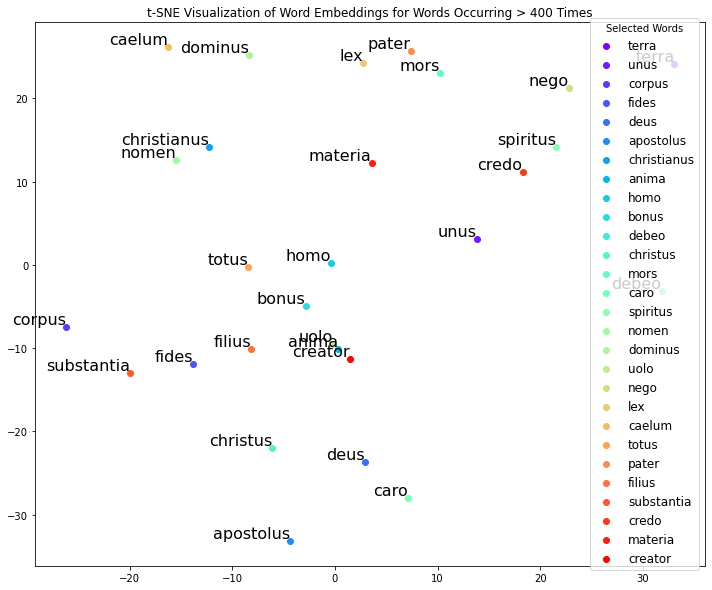

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import pairwise_distances

#Plot les mots qui apparaissent au moins 400 fois
#Paramètre à ajuster mais qui intervient que dans la visualisation
minimum = 400

#Je récupère ma matrice d'embedding
word_embeddings = model.layers[0].get_weights()[0]  # Your word embeddings matrix


# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
embedded_words = tsne.fit_transform(word_embeddings)

# Calculate pairwise distances between embedded words
distances = pairwise_distances(embedded_words)

# Plot the t-SNE visualization with labels for the top words
plt.figure(figsize=(12, 10))

# Ne garde les mots qui apparaissent au moins 400 fois
selected_words = [word for word, count in tokenizer.word_counts.items() if count > minimum]
print(selected_words)

# Define a colormap for the selected words based on distances
colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_words)))

for i, word in enumerate(selected_words):
    index = tokenizer.word_index.get(word)
    if index is not None:
        x, y = embedded_words[index, :]
        color = colors[i]
        plt.scatter(x, y, label=word, color=color)
        plt.text(x, y, word, fontsize=16, ha='right', va='bottom', color='black')

plt.title(f't-SNE Visualization of Word Embeddings for Words Occurring > {minimum} Times')
plt.legend(title='Selected Words', loc='center right', bbox_to_anchor=(1, 0.5), fontsize='large')
plt.show()


['terra', 'unus', 'corpus', 'fides', 'deus', 'apostolus', 'christianus', 'anima', 'homo', 'bonus', 'debeo', 'christus', 'mors', 'caro', 'spiritus', 'nomen', 'dominus', 'uolo', 'nego', 'lex', 'caelum', 'totus', 'pater', 'filius', 'substantia', 'credo', 'materia', 'creator']


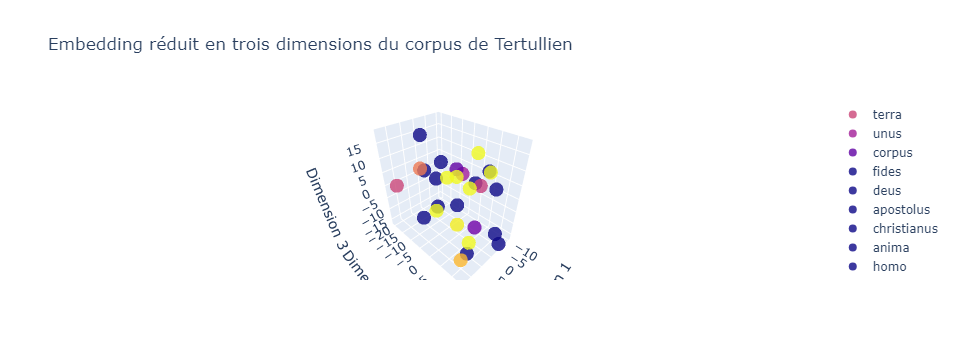

<Figure size 864x720 with 0 Axes>

In [31]:
import plotly.graph_objects as go
#Plot les mots qui apparaissent au moins 400 fois
#Paramètre à ajuster mais qui intervient que dans la visualisation
minimum = 400

#Je récupère ma matrice d'embedding
word_embeddings = model.layers[0].get_weights()[0]  # Your word embeddings matrix


# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=3, random_state=42)
embedded_words = tsne.fit_transform(word_embeddings)

# Calculate pairwise distances between embedded words
distances = pairwise_distances(embedded_words)

# Plot the t-SNE visualization with labels for the top words
plt.figure(figsize=(12, 10))

# Ne garde les mots qui apparaissent au moins 400 fois
selected_words = [word for word, count in tokenizer.word_counts.items() if count > minimum]

# Define a colormap for the selected words based on distances
colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_words)))

print(selected_words)

# for i, word in enumerate(selected_words):
#     index = tokenizer.word_index.get(word)
#     if index is not None:
#         x, y = embedded_words[index, :]
#         color = colors[i]
#         plt.scatter(x, y, label=word, color=color)
#         plt.text(x, y, word, fontsize=16, ha='right', va='bottom', color='black')

# plt.title(f't-SNE Visualization of Word Embeddings for Words Occurring > {minimum} Times')
# plt.legend(title='Selected Words', loc='center right', bbox_to_anchor=(1, 0.5), fontsize='large')
# plt.show()

# Create a 3D scatter plot with plotly
fig = go.Figure()

for i, word in enumerate(selected_words):
    index = tokenizer.word_index.get(word)
    color = colors[i]
    fig.add_trace(go.Scatter3d(
        x=[embedded_words[index, 0]],
        y=[embedded_words[index, 1]],
        z=[embedded_words[index, 2]],
        text=[word],
        mode='markers',
        marker=dict(
            size=8,
            color=color,  # You can use a color scale if needed
            opacity=0.8
        ),
        name=word
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3',
    ),
    title='Embedding réduit en trois dimensions du corpus de Tertullien'
)

# Display the plot in the notebook
fig.show()

# Save the plot as an HTML file
fig.write_html("interactive_3d_plot.html")


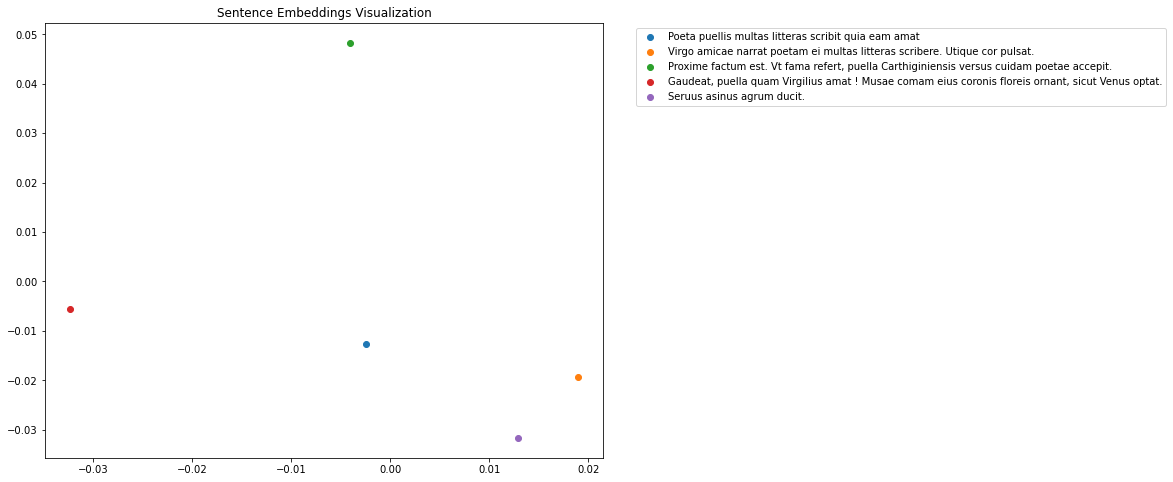

In [32]:
#J'ai essayé à l'échelle de la phrase mais c'est peu pertinent

# Assuming you have a list of sentences
sentences = ["Poeta puellis multas litteras scribit quia eam amat",
            "Virgo amicae narrat poetam ei multas litteras scribere. Utique cor pulsat.",
            "Proxime factum est. Vt fama refert, puella Carthiginiensis versus cuidam poetae accepit.",
            "Gaudeat, puella quam Virgilius amat ! Musae comam eius coronis floreis ornant, sicut Venus optat.",
            "Seruus asinus agrum ducit."] 


import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the model loaded and ready

# Tokenize and pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences to have consistent length
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Generate embeddings using the model
embeddings = model.layers[0].get_weights()[0]

# Function to calculate the Euclidean distance between two vectors
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# Function to visualize embeddings with legend on the right and outside the plot
def visualize_embeddings_with_legend(embeddings, sentences, title):
    plt.figure(figsize=(10, 8))
    for i, sentence in enumerate(sentences):
        plt.scatter(embeddings[i, 0], embeddings[i, 1], label=sentence)

    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Visualize embeddings with legend on the right and outside the plot
visualize_embeddings_with_legend(embeddings[:, :2], sentences, "Sentence Embeddings Visualization")

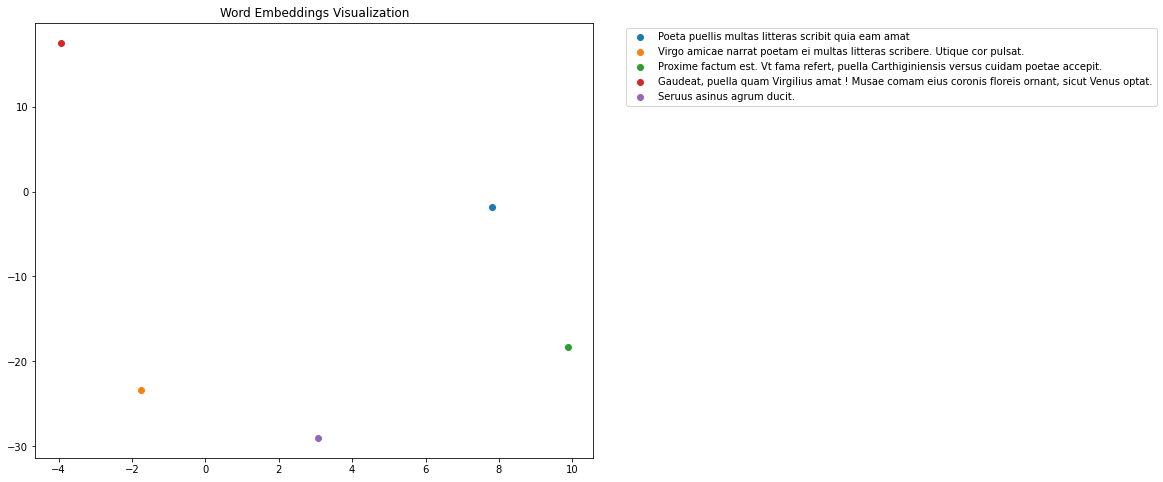

In [33]:
#Toujours à l'échelle de la phrase, peu pertinent
from sklearn.manifold import TSNE
embeddings_tsne = TSNE(n_components=2).fit_transform(embeddings)
visualize_embeddings_with_legend(embeddings_tsne, sentences, "Word Embeddings Visualization")

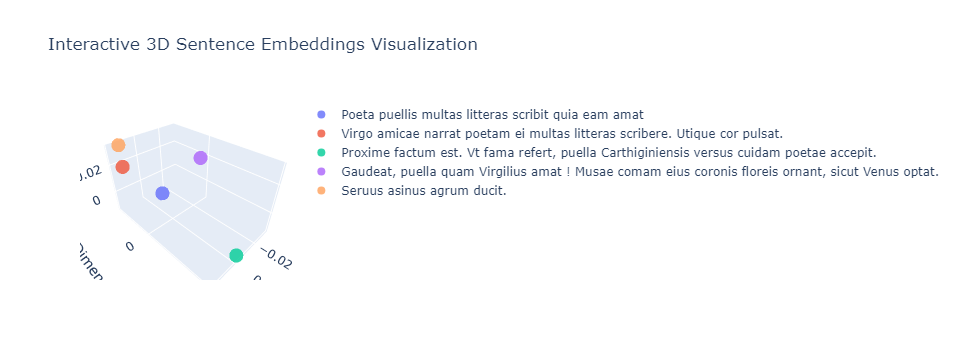

In [34]:
#La même chose en 3D
import plotly.graph_objects as go

# Assuming you have the model loaded and ready

# Tokenize and pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences to have consistent length
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Generate embeddings using the model
embeddings = model.layers[0].get_weights()[0]

# Create a 3D scatter plot with plotly
fig = go.Figure()

for i, sentence in enumerate(sentences):
    fig.add_trace(go.Scatter3d(
        x=[embeddings[i, 0]],
        y=[embeddings[i, 1]],
        z=[embeddings[i, 2]],
        text=[sentence],
        mode='markers',
        marker=dict(
            size=8,
            color=i,  # You can use a color scale if needed
            opacity=0.8
        ),
        name=sentence
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3',
    ),
    title='Interactive 3D Sentence Embeddings Visualization'
)

# Display the plot in the notebook
fig.show()

# Save the plot as an HTML file
fig.write_html("interactive_3d_plot.html")


1/1 [==============================] - 1s 634ms/step


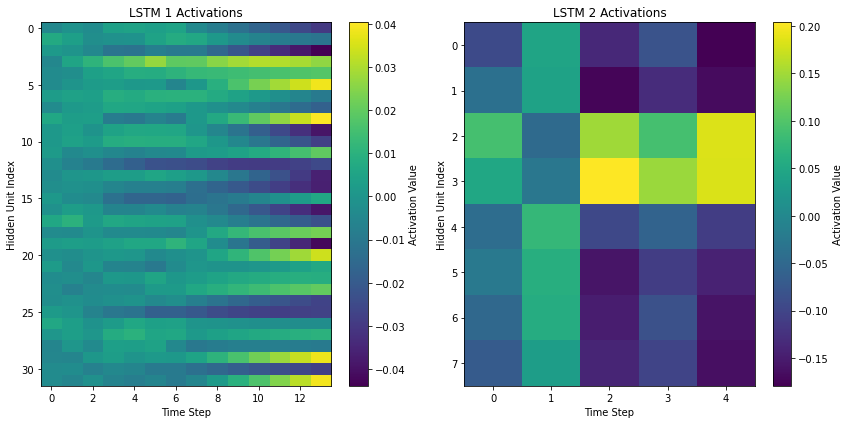

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a model with LSTM layers
# You may need to modify this based on your actual model architecture

# Tokenize and pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the activations of LSTM layers
activation_model = Model(inputs=model.input, outputs=[model.get_layer('lstm').output, model.get_layer('lstm_1').output])
# lstm1_activations, lstm2_activations = activation_model.predict(input_padded)
# print(lstm1_activations)
lstm1_activations, lstm2_activations = activation_model.predict(padded_sequences)


# Plot the activations with a colorbar
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(lstm1_activations[0].T, interpolation='nearest', cmap='viridis', aspect='auto')
plt.title('LSTM 1 Activations')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Index')
plt.colorbar(label='Activation Value')

plt.subplot(1, 2, 2)
plt.imshow(lstm2_activations[:20].T, interpolation='nearest', cmap='viridis', aspect='auto')
plt.title('LSTM 2 Activations')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Index')
plt.colorbar(label='Activation Value')


plt.tight_layout()
plt.show()


In [52]:
from sklearn.decomposition import NMF
import numpy as np

# Assuming 'word_embeddings' is your word embeddings matrix
# 'word_embeddings' should be a 2D array with dimensions (vocab_size, embedding_dim)

# Ensure all values are non-negative (replace negative values with zero)
word_embeddings_non_negative = np.maximum(word_embeddings, 0)

# Number of topics you want to extract
num_topics = 3

# # Create and fit NMF model
# nmf = NMF(n_components=num_topics, random_state=42)
# nmf.fit(word_embeddings_non_negative.T)

# Create and fit LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(word_embeddings_non_negative.T)

# Get the topic distributions for each word
word_topic_distributions = lda.transform(word_embeddings_non_negative.T)
# Print the top words for each topic
id_already_used_words=[]
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-word_embeddings_non_negative.shape[0]:-1]  # Get indices of top 10 words
    top_words=[]
    nb_id=0
    for id in top_words_idx:
        if not  id == 0:
            #Ici le 50 gère le nombre de mots que l'on veut dans le sujet
            if nb_id >=50:
                break
            if not id in id_already_used_words:
                top_words.append(next(word for word, index in word_index.items() if index == id))
                id_already_used_words.append(id)
                nb_id+=1
    print(f"Topic #{topic_idx + 1}:")
    print(top_words)

Topic #1:
['sodoma', 'mercurium', 'mancipo', 'situs', 'auxilium', 'aer', 'collum', 'prodigium', 'alternus', 'stupor', 'dominium', 'incuso', 'trepido', 'leuo', 'eicio', 'contristo', '±', 'socio', 'carnifex', 'statua', 'quamdiu', 'exsero', 'parento', 'agape', 'pressura', 'idea', 'inuito', 'demiurgus', 'sidus', 'sciscitor', 'intellectualis', 'aditus', 'imploro', 'medicina', 'continens', 'appello', 'assero', 'remunerator', 'nuncupo', 'assideo', 'monstruosus', 'miser', 'satisfacio', 'uulgaris', 'suffragium', 'rigor', 'laetus', 'cubile', 'cauterius', 'superduco']
Topic #2:
['aequum', 'luna', 'sex', 'arx', 'singularis', 'praeiudico', 'consumo', 'idololatres', 'huiusmodi', 'adiuuo', 'expugno', 'pignus', 'deditus', 'necne', 'intestinus', 'comprehendo', 'depositum', 'abominor', 'subtilitas', 'ruina', 'suspicor', 'nibil', 'substantiuus', 'affingo', 'uitulus', 'deseruio', 'sublimo', 'profundus', 'decursus', 'exaggero', 'dominator', 'macto', 'infatuo', 'currus', 'suspiro', 'praeministro', 'mollis',